# ***PROJECT - 3 Анализ воронки. Крапеницкая Е.Х.***

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Цель проекта:**

**Исследовать поведение пользователей в обновлённом приложении мобильной игры "Quiz Freeze".**

## **Задачи проекта:**

1. Определить, насколько обучение сокращает время прохождения этапов игры.

2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

3. Определить, насколько прозрачен процесс взаимодействия с игрой.

## **Конкретные шаги (формализованные задачи)**

1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **0. Сбор и обработка данных.**

In [2]:
# Импортируем библиотеку Pandas.

import pandas as pd 

### 0.1. Информация о событиях.

In [3]:
# Считываем данные из CSV-файла c событиями(events) и знакомимся с ними.

events_df = pd.read_csv('data/project3/Events.csv')
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585


In [4]:
# Проверяем типы данных в столбцах и изучаем пропущенные значения.

events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB


Дата в формате "object".
В столбцах "selected_level" и "tutorial_id" есть пропуски, это 
связано с тем, что обучение и выбор уровня сложности - события, 
которые происходят отдельно друг от друга. 


In [5]:
# Переводим дату в формат Datetime и проверяем успешность.

events_df['start_time'] = pd.to_datetime(events_df['start_time'], errors='coerce')
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11 23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11 23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12 00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12 01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12 01:34:53,17562.0,12585


In [6]:
# Так как по условию нужно делать анализ на основе данных пользователей,
# зарегистрировавшихся в 2018 году, фильтруем датафрейм по этому условию.

mask1 = events_df['start_time'] >= '2018-01-01'
mask2 = events_df['start_time'] < '2019-01-01'
mask3 = events_df['event_type'] == 'registration'

list_users = events_df[mask1&mask2&mask3]['user_id'].to_list()

events_df  = events_df[events_df['user_id'].isin(list_users)]

In [7]:
# Изучаем уникальные события в столбце "event_type".

events_df['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice'], dtype=object)

In [8]:
# Изучаем уникальные события в столбце "selected_level"

events_df['selected_level'].unique()

array([nan, 'medium', 'hard', 'easy'], dtype=object)

In [9]:
# Оцениваем, сколько пользователей совершали события.

events_df['user_id'].nunique()

19926

### 0.2. Информация о покупках.

In [10]:
# Считываем данные из файла с покупками(purchase) и знакомимся с ними.

purchase_df = pd.read_csv('data/project3/Purchase.csv')
purchase_df.head()

,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


In [11]:
# Проверяем типы данных и пропуски.

purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.3+ KB


In [12]:
# Переводим дату в формат Datetime.

purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], errors='coerce')

In [13]:
# Оставляем в датасете пользователей, зарегистрировавшихся в 2018 году.

purchase_df = purchase_df[purchase_df['user_id'].isin(list_users)]

In [14]:
# Оцениваем, сколько пользователей совершали покупки.

purchase_df['user_id'].nunique()
display(purchase_df)

,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03 18:53:43,100
1172,16846,27865,2018-01-04 14:46:10,250
1174,16848,27911,2018-01-07 08:19:12,50
1175,16849,27910,2018-01-07 12:11:34,100
1176,16850,27940,2018-01-07 13:16:41,200
...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100
2768,18442,47647,2019-01-02 23:26:26,150
2769,18443,47554,2019-01-03 00:36:36,50
2774,18448,47742,2019-01-04 12:51:41,50


### 0.3. Объединяем датафреймы.

In [15]:
# Создаем в датафрейме с оплатами событие "purchase".

purchase_df['event_type'] = 'purchase'

# Переименовываем столбцы для соответствия датафреймов друг другу.

events_df = events_df.rename(columns={'id': 'event_id'})
purchase_df = purchase_df.rename(columns={'id': 'purchase_id', 'event_datetime': 'start_time'})

# Объединяем датафреймы и сортируем по времени.

total_events_df = pd.concat([events_df, purchase_df], sort= False)
total_events_df = total_events_df.reset_index(drop= True).sort_values('start_time')
#total_events_df[total_events_df['event_type'] == 'purchase'].info()

display(total_events_df)

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Анализ данных.

## 1. Определяем, насколько обучение сокращает время прохождения этапов игры.

### 1.1. Вычислим пользователей, завершивших обучение и пользователей, не начинавших обучение и их процент от общего числа зарегистрировавшихся для видения общей картины по этим группам.

In [16]:
# Заносим количество зарегистрировавшихся пользователей в переменную "registered_users_count".

registered_users_count = total_events_df[total_events_df['event_type'] == 'registration'][
    'user_id'
].nunique()

print("Количество зарегистрировавшихся пользователей: {}".format(registered_users_count))

Количество зарегистрировавшихся пользователей: 19926


In [17]:
# Заносим количество пользователей, завершивших обучение, в переменную "tutorial_finish_users_count".

tutorial_finish_users_count = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].nunique()

print("Количество пользователей, завершивших обучение: {}".format(tutorial_finish_users_count))
print()

# Вычисляем процент пользователей, завершивших обучение.

percent_tutorial_finish_users = tutorial_finish_users_count / registered_users_count 

print("Процент пользователей, завершивших обучение от общего числа зарегистрировавшихся: {:.2%}".format(percent_tutorial_finish_users))

Количество пользователей, завершивших обучение: 10250

Процент пользователей, завершивших обучение от общего числа зарегистрировавшихся: 51.44%


In [18]:
# Вычисляем процент пользователей, не начинавших обучение.

# Пользователи, начавшие обучение.
tutorial_start_users_count = total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].nunique() 

# Пользователи, не начинавшие обучение.
not_tutorial_start_users_count = registered_users_count - tutorial_start_users_count

print("Количество пользователей, не начинавших обучение: {}".format(not_tutorial_start_users_count))
print()

percent_not_tutorial_start_users = not_tutorial_start_users_count / registered_users_count 

print("Процент пользователей, не начинавших обучение от общего числа зарегистрировавшихся: {:.2%}".format(percent_not_tutorial_start_users))


Количество пользователей, не начинавших обучение: 8068

Процент пользователей, не начинавших обучение от общего числа зарегистрировавшихся: 40.49%


#### Как мы видим, всего в 2018 году зарегистрировались 19926 пользователей.
#### Из них завершили обучение 10250(51.44%) пользователей.
#### 8068(40.49%) пользователей обучение не начинали.

#

### 1.2. Добавим в датафрейм столбец с метками по интересующим нас группам пользователей(завершившие обучение и не начинавшие его). 

In [19]:
# Создадим списки с пользователями по нашим группам.

users_with_finished_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique()

# Чтобы извлечь пользователей, не начинавших обучение, создадим два множества: все пользователи 
# и начинавшие обучение, а потом вычтем одно из другого.

all_users = total_events_df['user_id'].unique()
set_all_users = set(all_users)

users_with_started_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)

set_users_not_started_tutorial = set_all_users.difference(set_users_with_started_tutorial)
users_not_started_tutorial = list(set_users_not_started_tutorial)

In [20]:
# Создадим новый датафрейм, чтобы видоизменить его под нашу задачу, но сохранить исходный для других задач.

total_events_df_1 = total_events_df.copy()

display(total_events_df_1)

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [21]:
# Создадим функцию, которая будет принимать на вход столбец с пользователями из нашего датафрейма, а возвращать принадлежность к группе этого пользователя.

def status(x, user_id):
    if x[user_id] in users_with_finished_tutorial:
        return 'finished'
    elif x[user_id] in users_with_started_tutorial:
        return 'not_finished'
    else:
        return 'not_start'

# Создаем признак, показывающий в какую группу входит пользователь исходя из статуса его обучения(прошел/начал но неокончил/не проходил).

total_events_df_1['user_group'] = total_events_df_1.apply(lambda x: status(x, 'user_id'), axis=1)

total_events_df_1.head()


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount,user_group
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,not_start
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,finished
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,finished
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,finished
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,finished


In [22]:
# Оставляем только интересующие нас группы: окончившие и не начинавшие обучение. Группу с начавшими, но не окончившими обучение, удаляем.

total_events_df_1 = total_events_df_1[total_events_df_1['user_group'] != 'not_finished']

### 1.3. Вычислим время прохождения этапов игры для каждого пользователя.

#### Регистрация.

In [23]:
# Создаем датафрейм с регистрациями пользователей.

registration_df = total_events_df_1[total_events_df_1['event_type'] == 'registration']

# Проверяем, что на каждого пользователя в нашем датафрейме приходится одно событие.

registration_df['user_id'].value_counts().mean()

np.float64(1.0)

In [24]:
# Оставляем только нужные нам столбцы и переименовываем время для понятности.

registration_df = registration_df[['user_id', 'user_group', 'start_time']].rename(
    columns={'start_time': 'registration_time'}
)

# Смотрим, что получилось.

registration_df.head()

,user_id,user_group,registration_time
0,27832,not_start,2018-01-01 03:48:40
1,27833,finished,2018-01-01 04:07:25
2,27834,finished,2018-01-01 08:35:10
3,27835,finished,2018-01-01 11:54:47
4,27836,finished,2018-01-01 13:28:07


Начало обучения.

In [25]:
# Создаем датафрейм по началу обучения пользователей.

tutorial_start_df = total_events_df_1[total_events_df_1['event_type'] == 'tutorial_start']

# Проверяем, что на каждого пользователя в нашем датафрейме приходится одно событие.

tutorial_start_df['user_id'].value_counts().mean()


np.float64(1.5987317073170733)

#### Мы получили значение больше единицы. Это означает, что один пользователь может начать больше одного обучения за время пользования игрой.

#### Оставим только первое обучение.

In [26]:
# Сортируем датафрейм по времени и удаляем дубликаты в столбце "user_id",
# чтобы оставить только первое событие для пользователя.

tutorial_start_df = tutorial_start_df.sort_values(
    'start_time'
).drop_duplicates('user_id')

# Проверяем уникальность события для пользователя.

tutorial_start_df['user_id'].value_counts().mean()

np.float64(1.0)

In [27]:
# Оставляем только нужные столбцы(столбец "tutorial_id" понадобится нам позже) и переименовываем время.
# Проверяем, что получилось.

tutorial_start_df = tutorial_start_df[
    ['user_id', 'tutorial_id', 'user_group','start_time']
].rename(columns={'start_time': 'tutorial_start_time'})

tutorial_start_df.head()

,user_id,tutorial_id,user_group,tutorial_start_time
7,27836,31505.0,finished,2018-01-01 14:54:40
8,27835,31506.0,finished,2018-01-01 15:00:51
12,27833,31508.0,finished,2018-01-01 17:47:40
15,27839,31509.0,finished,2018-01-01 19:11:36
17,27834,31510.0,finished,2018-01-01 19:46:11


#### Вычисляем время между регистрацией и началом обучения для пользователей.
#### Для этого объединим получившиеся датафреймы.


In [28]:
# Объединяем и смотрим, что получилось.

registration_and_start_df = registration_df.merge(
    tutorial_start_df, on=['user_id','user_group'], how='inner'
)

registration_and_start_df.head()

,user_id,user_group,registration_time,tutorial_id,tutorial_start_time
0,27833,finished,2018-01-01 04:07:25,31508.0,2018-01-01 17:47:40
1,27834,finished,2018-01-01 08:35:10,31510.0,2018-01-01 19:46:11
2,27835,finished,2018-01-01 11:54:47,31506.0,2018-01-01 15:00:51
3,27836,finished,2018-01-01 13:28:07,31505.0,2018-01-01 14:54:40
4,27839,finished,2018-01-01 18:24:01,31509.0,2018-01-01 19:11:36


In [29]:
# Создаем столбец с разницей во времени между регистрацией и началом первого обучения.
# Смотрим результат.

registration_and_start_df ['timedelta'] = (
   registration_and_start_df ['tutorial_start_time'] - registration_and_start_df ['registration_time']
)
registration_and_start_df .head()

,user_id,user_group,registration_time,tutorial_id,tutorial_start_time,timedelta
0,27833,finished,2018-01-01 04:07:25,31508.0,2018-01-01 17:47:40,0 days 13:40:15
1,27834,finished,2018-01-01 08:35:10,31510.0,2018-01-01 19:46:11,0 days 11:11:01
2,27835,finished,2018-01-01 11:54:47,31506.0,2018-01-01 15:00:51,0 days 03:06:04
3,27836,finished,2018-01-01 13:28:07,31505.0,2018-01-01 14:54:40,0 days 01:26:33
4,27839,finished,2018-01-01 18:24:01,31509.0,2018-01-01 19:11:36,0 days 00:47:35


#### Вычисляем время между началом и окончанием обучения.

Так как пользователи могут несколько раз начинать и заканчивать обучение, вычислим время между началом и окончанием первого обучения.

In [30]:
# Создаем датафрейм с окончанием обучения.

tutorial_finish_df = total_events_df_1[total_events_df_1['event_type'] == 'tutorial_finish']

# Создаем список id обучений, взятых из датафрейма с первыми обучениями.

first_tutorial_ids = tutorial_start_df['tutorial_id'].unique()

# Фильтруем датафрейм с окончаниями обучений по этому списку.

tutorial_finish_df = tutorial_finish_df[
    tutorial_finish_df['tutorial_id'].isin(first_tutorial_ids)
]

# Проверим, что для каждого пользователя содержится по одному событию завершения обучения.

tutorial_finish_df['user_id'].value_counts().mean()

np.float64(1.0)

In [31]:
# Оставляем нужные столбцы, переименовываем время и смотрим результат.

tutorial_finish_df = tutorial_finish_df[['user_id', 'user_group', 'start_time']].rename(
    columns={'start_time': 'tutorial_finish_time'}
)
tutorial_finish_df.head()

,user_id,user_group,tutorial_finish_time
9,27835,finished,2018-01-01 15:06:15
13,27833,finished,2018-01-01 17:50:08
16,27839,finished,2018-01-01 19:16:32
18,27834,finished,2018-01-01 19:48:01
31,27845,finished,2018-01-02 03:06:48


In [32]:
# Объединяем датафреймы с началом и окончанием обучения.

start_finish_df = tutorial_start_df.merge(
    tutorial_finish_df, on=['user_id','user_group'], how='inner'
)

# Создаем столбец с разницей во времени между началом и окончанием первого обучения.

start_finish_df['timedelta'] = (
    start_finish_df['tutorial_finish_time'] - start_finish_df['tutorial_start_time']
)

start_finish_df.head()

,user_id,tutorial_id,user_group,tutorial_start_time,tutorial_finish_time,timedelta
0,27835,31506.0,finished,2018-01-01 15:00:51,2018-01-01 15:06:15,0 days 00:05:24
1,27833,31508.0,finished,2018-01-01 17:47:40,2018-01-01 17:50:08,0 days 00:02:28
2,27839,31509.0,finished,2018-01-01 19:11:36,2018-01-01 19:16:32,0 days 00:04:56
3,27834,31510.0,finished,2018-01-01 19:46:11,2018-01-01 19:48:01,0 days 00:01:50
4,27845,31512.0,finished,2018-01-02 03:03:44,2018-01-02 03:06:48,0 days 00:03:04


#### Так как этап выбора уровня сложности может следовать и до начала и окончания обучения, чтобы не путать данные, вычислим время между регистрацией и выбором уровня сложности.

In [33]:
# Создаем датафрейм с выбором уровня сложности.
# Проверяем уникальность событий для пользователей.
# Оставляем только нужные столбцы и переименовываем их.

level_choice_df = total_events_df_1[total_events_df_1['event_type'] == 'level_choice']

print(level_choice_df['user_id'].value_counts().mean())

level_choice_df = level_choice_df[['user_id', 'user_group', 'start_time']].rename(
    columns={'start_time': 'level_choice_time'}
)

1.0


In [34]:
# Объединяем датафреймы.

registration_level_choice_df = registration_df.merge(level_choice_df, on=['user_id','user_group'], how='inner')

# Создаем столбец с разницей во времени между регистрацией и выбором уровня сложности, смотрим на результат.

registration_level_choice_df['timedelta'] = (
    registration_level_choice_df['level_choice_time'] - registration_level_choice_df['registration_time']
)
registration_level_choice_df.head()

,user_id,user_group,registration_time,level_choice_time,timedelta
0,27835,finished,2018-01-01 11:54:47,2018-01-01 20:37:22,0 days 08:42:35
1,27839,finished,2018-01-01 18:24:01,2018-01-01 22:37:50,0 days 04:13:49
2,27842,finished,2018-01-01 23:18:46,2018-01-02 08:46:03,0 days 09:27:17
3,27843,finished,2018-01-02 00:02:28,2018-01-02 14:09:58,0 days 14:07:30
4,27845,finished,2018-01-02 01:35:56,2018-01-02 06:19:18,0 days 04:43:22


#### Вычисляем время между выбором уровня сложности тренировки и выбором набора бесплатных вопросов.

In [35]:
# Создаем датафрейм с выбором пакета вопросов.
# Проверяем уникальность событий для пользователей.
# Оставляем только нужные столбцы и переименовываем их.


pack_choice_df = total_events_df_1[total_events_df_1['event_type'] == 'pack_choice']

print(pack_choice_df['user_id'].value_counts().mean())

pack_choice_df = pack_choice_df[['user_id', 'user_group', 'start_time']].rename(
    columns={'start_time': 'pack_choice_time'}
)

1.0


In [36]:
# Объединяем датафреймы.

level_pack_choice_df = level_choice_df.merge(pack_choice_df, on=['user_id','user_group'], how='inner')

# Создаем столбец с разницей во времени между выбором уровня сложности и выбором пакета бесплатных вопросов.

level_pack_choice_df['timedelta'] = (
    level_pack_choice_df['pack_choice_time'] - level_pack_choice_df['level_choice_time']
)
level_pack_choice_df.head()



,user_id,user_group,level_choice_time,pack_choice_time,timedelta
0,27835,finished,2018-01-01 20:37:22,2018-01-01 20:38:43,0 days 00:01:21
1,27839,finished,2018-01-01 22:37:50,2018-01-01 22:42:54,0 days 00:05:04
2,27845,finished,2018-01-02 06:19:18,2018-01-02 06:25:12,0 days 00:05:54
3,27849,finished,2018-01-02 11:53:11,2018-01-02 11:59:26,0 days 00:06:15
4,27843,finished,2018-01-02 14:09:58,2018-01-02 14:14:51,0 days 00:04:53


#### Вычислим время между выбором бесплатных вопросов и первой покупкой.

In [37]:
# Создаем датафрейм с покупками пакетов вопросов.
# Проверяем уникальность событий для пользователей.
# Оставляем только нужные столбцы и переименовываем их.

purchase_total_df = total_events_df_1[total_events_df_1['event_type'] == 'purchase']

print(purchase_total_df['user_id'].value_counts().mean())

purchase_total_df = purchase_total_df[['user_id', 'user_group', 'start_time']].rename(
    columns={'start_time': 'purchase_time'}
)


1.0


In [38]:
# Объединяем датафреймы.

pack_choice_purchase_df = pack_choice_df.merge(purchase_total_df, on=['user_id','user_group'], how='inner')

# Создаем столбец с разницей во времени между выбором бесплатных вопросов и покупкой.

pack_choice_purchase_df['timedelta'] = (
    pack_choice_purchase_df['purchase_time'] - pack_choice_purchase_df['pack_choice_time']
)

pack_choice_purchase_df.head()

,user_id,user_group,pack_choice_time,purchase_time,timedelta
0,27845,finished,2018-01-02 06:25:12,2018-01-03 18:53:43,1 days 12:28:31
1,27884,finished,2018-01-04 16:22:03,2018-01-08 19:37:34,4 days 03:15:31
2,27910,finished,2018-01-05 12:05:28,2018-01-07 12:11:34,2 days 00:06:06
3,27940,finished,2018-01-06 00:39:06,2018-01-07 13:16:41,1 days 12:37:35
4,27969,finished,2018-01-06 20:36:37,2018-01-08 01:18:23,1 days 04:41:46


### 1.4. Сравниваем время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение.

#### Этап "Регистрация - начало обучения".

Мы не можем сравнить время прохождения этого этапа между нашими группами, так как пользователи второй группы не начинали обучение.

Но мы можем изучить этот путь у первой группы.

In [39]:
registration_and_start_df[registration_and_start_df['user_group'] == 'finished']['timedelta'].describe()

count                        10250
mean     0 days 04:31:04.938146341
std      0 days 04:11:24.828137380
min                0 days 00:00:34
25%         0 days 01:17:55.500000
50%                0 days 03:13:48
75%         0 days 06:37:27.750000
max                1 days 16:03:46
Name: timedelta, dtype: object

#### Мы видим, что у пользователей, окончивших обучение, среднее время между регистрацией и началом обучения составляет 4 часа 31 минуту.
##### Четверть пользователей тратят на это примерно 1 час 17 минут.
##### У половины пользователей этот промежуток составляет примерно 3 часа 13 минут.
##### Среднее время более чем на час выше медианного. Это говорит о том, что есть пoльзователи, которые долго проходят этот этап. 
##### Можно изучить их подробнее, чтобы понять, что мешает им быстрее дойти до этапа обучения.

#

#### Для сравнения времени прохождения этапов мы будем использовать медианное время, так как на него меньше влияют единичные пользователи с аномально долгим временем, затраченным на этапы. В связи с этим медианное время даст более точную картину.

In [40]:
# Cоздадим сводную таблицу с медианной разницей во времени между регистрацией и началом обучения, распределенной по нашим группам пользователей.
# Эту таблицу мы используем в дальнейшем, соединив ее с таблицами по другим этапам.

registration_start = registration_and_start_df.pivot_table(values='timedelta', index='user_group', aggfunc='median')
display(registration_start)

,timedelta
user_group,
finished,0 days 03:13:48


#### Этап "Начало - конец обучения".

По тем же причинам мы не будем сравнивать время прохождения этого этапа по группам, а изучим его для пользователей, заканчивших обучение.

In [41]:
start_finish_df[start_finish_df['user_group'] == 'finished']['timedelta'].describe()

count                         9830
mean     0 days 00:03:53.174160732
std      0 days 00:01:44.803217992
min                0 days 00:00:16
25%                0 days 00:02:28
50%                0 days 00:03:42
75%                0 days 00:05:08
max                0 days 00:10:06
Name: timedelta, dtype: object

##### Мы видим, что среднее время прохождения игры среди пользователей, окончивших обучение, составляет 3 часа 53 минуты, половина пользователей тратит на игру примерно 3 часа 42 минуты.

In [42]:
# Создаем сводную таблицу для этапа "начало-конец обучения".

start_finish = start_finish_df.pivot_table(values='timedelta', index='user_group', aggfunc='median')

#### Этап "Регистрация - выбор уровня сложности".


Мы сравним время прохождения этого этапа пользователями, окончившими обучение и пользователями, не начинавшими его.

In [43]:
# Построим сводную таблицу, в которой индексами строк будут группы пользователей, а значениями медианы разницы во времени между нашими этапами.

reg_level = registration_level_choice_df.pivot_table(values='timedelta', index='user_group', aggfunc='median')

display(reg_level)

,timedelta
user_group,
finished,0 days 06:00:07
not_start,0 days 04:56:05.500000


#### Этап "Выбор уровня сложности - выбор пакета бесплатных вопросов".

In [44]:
# Создаем сводную таблицу и для этого этапа. 
 
level_pack_choice = level_pack_choice_df.pivot_table(values='timedelta', index='user_group', aggfunc='median')

display(level_pack_choice)

,timedelta
user_group,
finished,0 days 00:04:58
not_start,0 days 00:04:46.500000


#### Этап "Выбор бесплатных вопросов - покупка платного пакета вопросов."

In [45]:
# Создаем сводную.

pack_choice_purchase = pack_choice_purchase_df.pivot_table(values='timedelta', index='user_group', aggfunc='median')

display(pack_choice_purchase)

,timedelta
user_group,
finished,3 days 12:15:56
not_start,4 days 04:38:42


#### Объединяем наши таблицы в одну для удобства визуализации.

In [46]:
total_pivot_timedelta = registration_start.join(start_finish, on='user_group',how='outer', lsuffix='_registration_start', rsuffix='_start_finish')

total_pivot_timedelta = total_pivot_timedelta.merge(reg_level, on='user_group',how='outer')
total_pivot_timedelta = total_pivot_timedelta.rename(columns={'timedelta': 'timedelta_registration_level_choice'})

total_pivot_timedelta = total_pivot_timedelta.merge(level_pack_choice, on='user_group',how='outer')
total_pivot_timedelta = total_pivot_timedelta.rename(columns={'timedelta': 'timedelta_level_pack_choice'})

total_pivot_timedelta = total_pivot_timedelta.merge(pack_choice_purchase, on='user_group',how='outer')
total_pivot_timedelta = total_pivot_timedelta.rename(columns={'timedelta': 'timedelta_pack_choice_purchase'})

display(total_pivot_timedelta)

,timedelta_registration_start,timedelta_start_finish,timedelta_registration_level_choice,timedelta_level_pack_choice,timedelta_pack_choice_purchase
user_group,,,,,
finished,0 days 03:13:48,0 days 00:03:42,0 days 06:00:07,0 days 00:04:58,3 days 12:15:56
not_start,NaT,NaT,0 days 04:56:05.500000,0 days 00:04:46.500000,4 days 04:38:42


In [47]:
# Переводим время в часы для адекватной визуализации.

total_pivot_timedelta = total_pivot_timedelta.apply(lambda x: x/pd.Timedelta('1 hour'))

display(total_pivot_timedelta)

,timedelta_registration_start,timedelta_start_finish,timedelta_registration_level_choice,timedelta_level_pack_choice,timedelta_pack_choice_purchase
user_group,,,,,
finished,3.23,0.061667,6.001944,0.082778,84.265556
not_start,NaN,NaN,4.934861,0.079583,100.645000


У нас получилась таблица, в которой часы прохождения каждого этапа разбиты по группам пользователей: окончившие обучение и не начинавшие его.

#### Приступим к визуализации.

In [48]:
# Импортируем библиотеку для построения графиков.

import matplotlib.pyplot as plt
%matplotlib inline


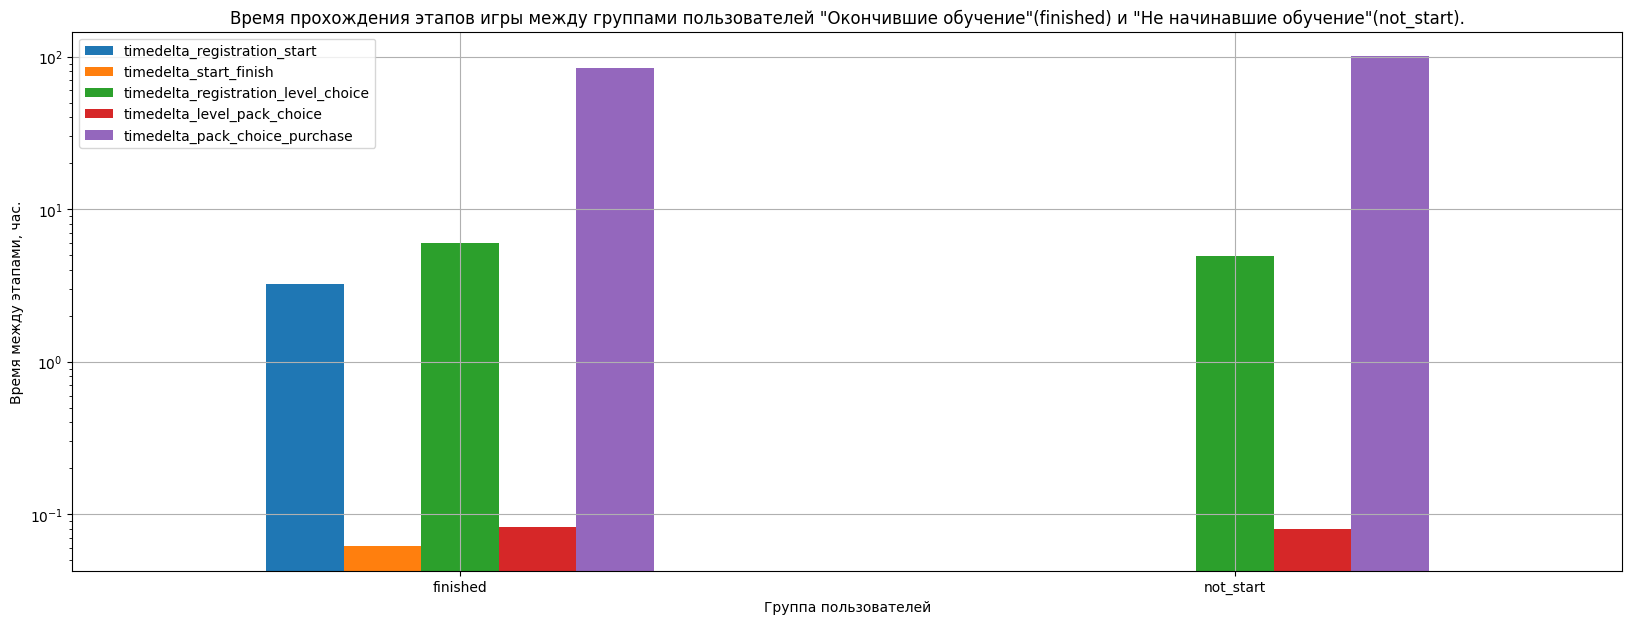

In [49]:
fig = total_pivot_timedelta.plot(
    kind='bar',
    grid=True,
    figsize=(20, 7)
)
plt.ylabel('Время между этапами, час.')
plt.xlabel('Группа пользователей')
plt.title('Время прохождения этапов игры между группами пользователей "Окончившие обучение"(finished) и "Не начинавшие обучение"(not_start).')
plt.xticks(rotation=0)
plt.semilogy()
plt.show()

#### Добавим цифр для лучшего понимания. Посчитаем разницу прохождения этапов между группой "Окончившие обучение" и группой "Не начинавшие обучение".

In [50]:
# С помощью функции отнимаем из времени прохождения этапов первой группой, время прохождения этих же этапов второй групппой.
import warnings
warnings.simplefilter('ignore')
difference = total_pivot_timedelta.apply(lambda x: x[0] - x[1])
display(difference)

timedelta_registration_start                 NaN
timedelta_start_finish                       NaN
timedelta_registration_level_choice     1.067083
timedelta_level_pack_choice             0.003194
timedelta_pack_choice_purchase        -16.379444
dtype: float64

##### Как мы видим, между пользователями, окончившими обучение, и пользователями, не начинавшими его, есть разница во времени прохождения этапов игры. 

##### Этап между регистрацией и выбором уровня сложности игры быстрее проходят пользователи, не начинавшие обучение.  

##### Разница во времени составляет чуть больше часа. Это можно объяснить тем, что вторая группа пользователей не тратит время на обучение, а сразу переходит к выбору уровня сложности.

##### На этапе между выбором уровня сложности игры и выбором пакета бесплатных вопросов между группами пользователей нет разницы по времени прохождения(разницу в 12 секунд можно считать погрешностью).  
 ##### Можно сделать вывод что обучение не влияет на время прохождения этого этапа.

##### Этап между выбором пакета бесплатных вопросов и покупкой пользователи, окончившие обучение, проходят значительно быстрее пользователей, обучение не начинавших.  

##### Разница составляет более 16 часов. Можно сделать вывод что прохождение обучения быстрее приводит пользователя к совершению покупки. 

#

## 2. Докажем, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

Для решения этой задачи нам нужно сгруппировать пользователей по количеству законченных ими обучений.

In [51]:
# Создадим новый датафрейм для решения нашей задачи.

total_events_df_2 = total_events_df.copy()



### 2.1. Вычисляем количество оконченных обучений для каждого пользователя.

In [52]:
# Фильтруем наш датафрейм по событию "tutorial_finish"

total_events_df_2_finished = total_events_df_2[total_events_df_2['event_type'] == 'tutorial_finish']

# Группируем событие "tutorial_finish" по пользователям.
groupby_finished = total_events_df_2_finished.pivot_table(index='user_id', values='event_type', aggfunc='count')
groupby_finished = groupby_finished.reset_index()

# Переименовываем столбец с подсчитанными окончаниями обучений для удобства и проверяем, что получилось.
groupby_finished = groupby_finished.rename(columns={'event_type': 'count_tutorial'})

display(groupby_finished)



,user_id,count_tutorial
0,27833,1
1,27834,1
2,27835,1
3,27836,1
4,27839,1
...,...,...
10245,47748,1
10246,47751,1
10247,47753,1
10248,47755,1


In [53]:
# Выделим пользователей, которые не закончили обучение ни разу.
# Составим список этих пользователей.

total_events_df_2_not_finished = total_events_df_2[~total_events_df_2['user_id'].isin(users_with_finished_tutorial)]

# Создаем столбец с оконченными обучениями(со значением "0") и в этом датафрейме, чтобы объединить его с предыдущим.

total_events_df_2_not_finished['count_tutorial'] = 0

# Оставляем только нужные нам столбцы.

groupby_not_finished = total_events_df_2_not_finished[['user_id', 'count_tutorial']]

# Удаляем дубликаты. Смотрим, что получилось.

groupby_not_finished = groupby_not_finished.drop_duplicates('user_id')

display(groupby_not_finished)


,user_id,count_tutorial
0,27832,0
5,27837,0
6,27838,0
21,27840,0
27,27844,0
...,...,...
66936,47749,0
66938,47750,0
66940,47752,0
66942,47754,0


In [54]:
# Объединим получившиеся таблицы.

grouped_count_tutorial = pd.concat([groupby_finished, groupby_not_finished], ignore_index=True)

display(grouped_count_tutorial)

,user_id,count_tutorial
0,27833,1
1,27834,1
2,27835,1
3,27836,1
4,27839,1
...,...,...
19921,47749,0
19922,47750,0
19923,47752,0
19924,47754,0


In [55]:
# Теперь совершим обратное действие и сгруппируем количество пользователей по количеству оконченных обучений.
 
total_count_tutorial = grouped_count_tutorial.pivot_table(index='count_tutorial', values='user_id', aggfunc='count')
total_count_tutorial = total_count_tutorial.reset_index()
total_count_tutorial = total_count_tutorial.rename(columns={'user_id': 'total_users'})

display(total_count_tutorial)

,count_tutorial,total_users
0,0,9676
1,1,8015
2,2,1321
3,3,345
4,4,178
5,5,117
6,6,101
7,7,97
8,8,54
9,9,22


У нас получился датафрейм с пользователями, сгруппированными по количеству оконченных ими обучений. Уже на данном этапе видно, что пользователей, со значением оконченных обучений 0, больше других. Это говорит о том, что многие пользователи(9676 человек), не закончили обучение ни разу.

### 2.2. Теперь вычислим, как оплаты распределены по количеству обучений.

In [56]:
# Присоединим получившийся датафрейм к исходному.

total_events_df_2 = total_events_df_2.merge(grouped_count_tutorial, how='outer', on='user_id')

# Оставим в датафрейме только событие "purchase", так как другие события нам не интересны на этом этапе.

total_events_df_2 = total_events_df_2[total_events_df_2['event_type'] == 'purchase']

display(total_events_df_2)



,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount,count_tutorial
49,NaN,purchase,NaN,2018-01-03 18:53:43,NaN,27845,16845.0,100.0,2
123,NaN,purchase,NaN,2018-01-04 14:46:10,NaN,27865,16846.0,250.0,0
174,NaN,purchase,NaN,2018-01-08 19:37:34,NaN,27884,16854.0,150.0,2
243,NaN,purchase,NaN,2018-01-07 12:11:34,NaN,27910,16849.0,100.0,1
248,NaN,purchase,NaN,2018-01-07 08:19:12,NaN,27911,16848.0,50.0,0
...,...,...,...,...,...,...,...,...,...
68318,NaN,purchase,NaN,2018-12-30 01:39:50,NaN,47671,18429.0,200.0,1
68349,NaN,purchase,NaN,2018-12-30 09:05:28,NaN,47687,18432.0,100.0,1
68428,NaN,purchase,NaN,2018-12-31 09:05:20,NaN,47712,18434.0,50.0,1
68488,NaN,purchase,NaN,2019-01-06 07:14:25,NaN,47732,18452.0,150.0,1


In [57]:
# Так как, изучая исходный датафрейм с оплатами, мы выяснили, что на одного пользователя приходится одна оплата,
# мы можем создать нужную нам таблицу, просто посчитав количество оплативших пользователей, сгруппировав их 
# по количеству оконченных обучений.

purchase_count_tutorial = total_events_df_2.pivot_table(index='count_tutorial', values='user_id', aggfunc='count')
purchase_count_tutorial = purchase_count_tutorial.reset_index()
purchase_count_tutorial = purchase_count_tutorial.rename(columns={'user_id': 'purchase_users'})

display(purchase_count_tutorial)



,count_tutorial,purchase_users
0,0,153
1,1,1143
2,2,182
3,3,44
4,4,19
5,5,19
6,6,15
7,7,15
8,8,6
9,9,4


Мы получили таблицу с оплатами, сгруппированными по количеству обучений. Присоединим ее к таблице с общим количеством пользователей.

In [58]:
# Объединим получившиеся таблицы.

total_count_tutorial = total_count_tutorial.merge(purchase_count_tutorial, on='count_tutorial')

display(total_count_tutorial)


,count_tutorial,total_users,purchase_users
0,0,9676,153
1,1,8015,1143
2,2,1321,182
3,3,345,44
4,4,178,19
5,5,117,19
6,6,101,15
7,7,97,15
8,8,54,6
9,9,22,4


Теперь нам нужно вычислить процент оплат от общего количества пользователей по каждой группе пользователей.

In [59]:
total_count_tutorial['percent_purchases'] = (total_count_tutorial['purchase_users']/total_count_tutorial['total_users'] * 100).round(2)

display(total_count_tutorial)

,count_tutorial,total_users,purchase_users,percent_purchases
0,0,9676,153,1.58
1,1,8015,1143,14.26
2,2,1321,182,13.78
3,3,345,44,12.75
4,4,178,19,10.67
5,5,117,19,16.24
6,6,101,15,14.85
7,7,97,15,15.46
8,8,54,6,11.11
9,9,22,4,18.18


### 2.3. Добавим визуализацию.

Создадим 2 столбчатые диаграммы. Первая будет отражать процент оплат, совершенных пользователями от общего количества пользователей, а второй - распределение количества пользователей по числу оконченных ими обучений.

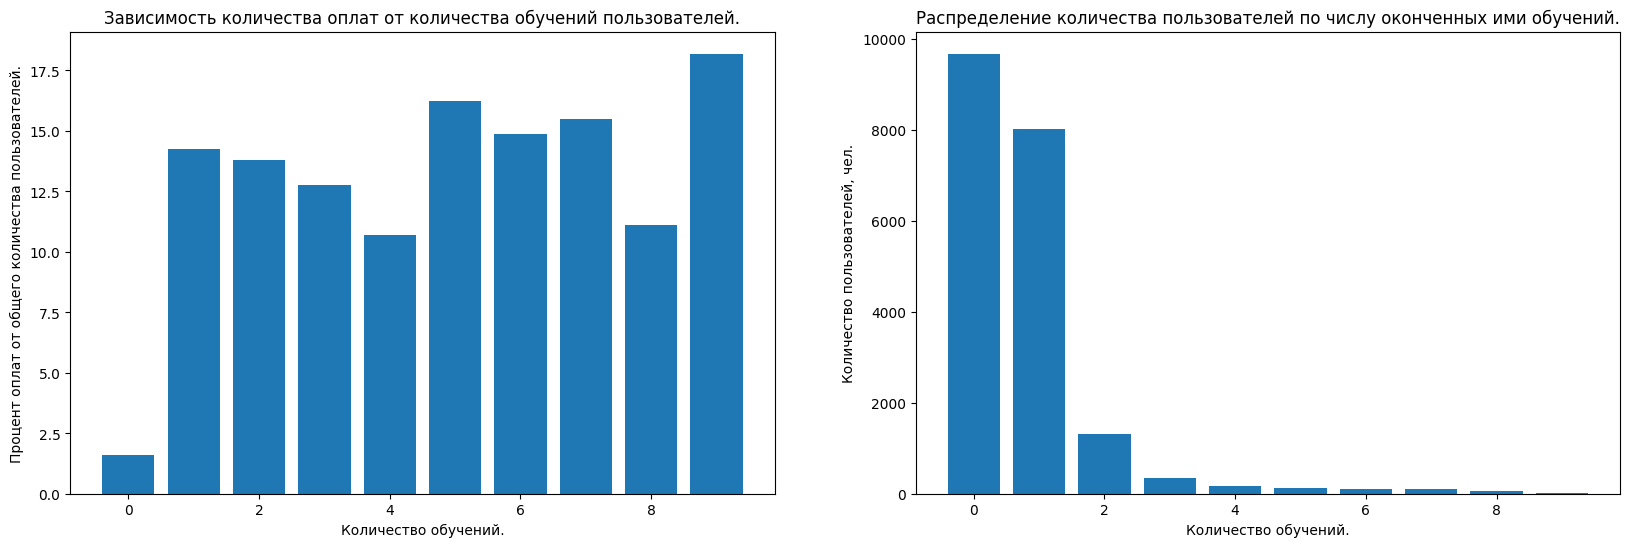

In [60]:
# Создадим 2 графика на одной фигуре с помощью метода subplots. 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# График с процентом оплат.

axes[0].bar(x=total_count_tutorial['count_tutorial'], 
            height= total_count_tutorial['percent_purchases'], 
            )
axes[0].set_title('Зависимость количества оплат от количества обучений пользователей.')
axes[0].set_xlabel('Количество обучений.')
axes[0].set_ylabel('Процент оплат от общего количества пользователей.')

# График с общим количеством пользователей.

axes[1].bar(x=total_count_tutorial['count_tutorial'],
            height= total_count_tutorial['total_users']
            )
axes[1].set_title('Распределение количества пользователей по числу оконченных ими обучений.')
axes[1].set_xlabel('Количество обучений.')
axes[1].set_ylabel('Количество пользователей, чел.');


##### Первый график показывает влияние количества оконченных обучений на оплаты, совершенные пользователями. Мы видим прямую зависимость оплат от обучения.  
#####  У пользователей, ни разу не окончивших обучение, очень низкий процент оплат(1.58%).
  ##### У пользователей с оконченными обучениями этот процент гораздо выше(от 10.64% до 18.18%). Причем у пользователей с максимальным количеством обучений(9), этот процент самый высокий. Но это может быть связано с тем, что этих пользователей очень мало(22 человека) для адекватного анализа. 

#

##### На втором графике все пользователи распределены по количеству пройденных ими обучений. Мы видим, что наибольшее количество пользователей(9676 чел.) обучение не проходят, меньшее количество пользователей(8015 чел.) проходят одно обучение, значительно меньше(от 1321 до 22 чел.) проходят 2 обучения и больше. 

#

## 3. Определим, насколько прозрачен процесс взаимодействия с игрой.

Для этого мы выясним, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [61]:
# Копируем исходный датафрейм.

total_events_df_3 = total_events_df.copy()
display(total_events_df_3)


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


Нам нужно вычислить разницу во времени между началом обучения и выбором уровня сложности по каждому пользователю. Если разница отрицательная, значит, пользователь начал обучение после выбора уровня сложности.

Для нашей цели нужно вычислить время последнего начала обучений пользователей и время их выбора уровня сложности.

### 3.1. Создадим датафрейм с последними началами обучений пользователей.

In [62]:
# Фильтруем датафрейм по событию "tutorial_start".

tutorial_start_time = total_events_df_3[total_events_df_3['event_type'] == 'tutorial_start']

# Сортируем по времени в порядке убывания и оставляем только последнее событие для пользователя.


tutorial_start_time = tutorial_start_time.sort_values('start_time', ascending=False).drop_duplicates('user_id')

# Проверяем, что на пользователя приходится одно событие.

tutorial_start_time['user_id'].value_counts().mean()


np.float64(1.0)

In [63]:
# Оставляем только нужные нам столбцы и переименовываем столбец со временем.

tutorial_start_time = tutorial_start_time[['user_id', 'start_time']].rename(
    columns={'start_time': 'tutorial_start_time'}
)

tutorial_start_time.head()

,user_id,tutorial_start_time
66954,47756,2019-01-01 03:26:18
66952,47755,2019-01-01 00:08:14
66945,47753,2018-12-31 20:54:56
66943,47751,2018-12-31 19:38:14
66934,47747,2018-12-31 10:21:11


### 3.2. Cоздадим датафрейм с первым выбором уровня сложности для пользователей.

In [64]:
# Фильтруем датафрейм по событию "level_choice".

level_choice_time = total_events_df_3[total_events_df_3['event_type'] == 'level_choice']

# Проверяем, сколько событий приходится на пользователя.

print(level_choice_time['user_id'].value_counts().mean())

1.0


Мы видим, что на пользователя приходится одно событие, значит, пользователи выбирают уровень сложности один раз.

In [65]:
# Оставляем только нужные столбцы и переименовываем время.

level_choice_time = level_choice_time[['user_id', 'start_time']].rename(
    columns={'start_time': 'level_choice_time'}
)

display(level_choice_time)



,user_id,level_choice_time
19,27835,2018-01-01 20:37:22
23,27839,2018-01-01 22:37:50
36,27840,2018-01-02 05:18:42
38,27845,2018-01-02 06:19:18
45,27842,2018-01-02 08:46:03
...,...,...
66932,47732,2018-12-31 09:59:00
66937,47747,2018-12-31 12:24:40
66948,47753,2018-12-31 22:36:19
66956,47755,2019-01-01 05:04:52


### 3.3. Посчитаем разницу во времени между выбором уровня сложности и началом последнего обучения пользователей.

In [66]:
# Теперь соединим наши таблицы и создадим столбец с разницей во времени между выбором уровня сложности и последним началом обучения пользователей.

difference_level_tutorial = level_choice_time.merge(tutorial_start_time, on='user_id', how='inner')

difference_level_tutorial['timedelta'] = (
    difference_level_tutorial['tutorial_start_time'] - difference_level_tutorial['level_choice_time']
)

# Для удобства подсчетов переведем время в часы.

difference_level_tutorial['timedelta'] = difference_level_tutorial['timedelta'].apply(lambda x: x/pd.Timedelta('1 hour'))

display(difference_level_tutorial)

,user_id,level_choice_time,tutorial_start_time,timedelta
0,27835,2018-01-01 20:37:22,2018-01-01 15:00:51,-5.608611
1,27839,2018-01-01 22:37:50,2018-01-01 19:11:36,-3.437222
2,27840,2018-01-02 05:18:42,2018-01-02 02:07:07,-3.193056
3,27845,2018-01-02 06:19:18,2018-01-02 07:08:00,0.811667
4,27842,2018-01-02 08:46:03,2018-01-02 18:08:01,9.366111
...,...,...,...,...
8239,47732,2018-12-31 09:59:00,2018-12-31 07:14:38,-2.739444
8240,47747,2018-12-31 12:24:40,2018-12-31 10:21:11,-2.058056
8241,47753,2018-12-31 22:36:19,2018-12-31 20:54:56,-1.689722
8242,47755,2019-01-01 05:04:52,2019-01-01 00:08:14,-4.943889


### 3.4. Посчитаем, какой процент пользователей(от общего числа) начинает обучение после выбора уровня сложности в игре.

Посмотрим общее количество пользователей.

In [67]:
total_users_count = total_events_df_3['user_id'].nunique()
print("Общее количество пользователей: {}".format(total_users_count))

Общее количество пользователей: 19926


Вычислим пользователей, начавших обучение после выбора уровны сложности.

In [68]:
after_users_count = difference_level_tutorial[difference_level_tutorial['timedelta'] < 0]['user_id'].nunique()
print("Количество пользователей, начавших обучение после выбора уровня сложности: {}".format(after_users_count))

Количество пользователей, начавших обучение после выбора уровня сложности: 6858


Наконец, посчитаем, какой процент пользователей(от общего числа) начинает обучение после выбора уровня сложности в игре.

In [69]:
percent_tutorial_after = after_users_count/total_users_count

print("Процент пользователей(от общего количества), начавших обучение после выбора уровня сложности: {:.2%}".format(percent_tutorial_after))

Процент пользователей(от общего количества), начавших обучение после выбора уровня сложности: 34.42%


##### Как мы видим, больше трети пользователей начинают обучение после выбора уровня сложности тренировок. 
##### Это говорит о том, что процесс взаимодействия с игрой недостаточно прост для пользователей.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Выводы.**

### **Вывод 1**(насколько обучение сокращает время прохождения этапов игры):

- Пользователи, прошедшие обучение более, чем на 16 часов быстрее проходят этап игры между выбором пакета бесплатных вопросов и покупкой платных вопросов. 

- В прохождении других этапов игры значительной разницы не наблюдается.

- Можно с уверенность сказать, что пройденное обучение значительно сокращает время до оплаты.


### **Вывод 2**(существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь):

- Существует прямая зависимость между обучением и оплатами.

- У пользователей, ни разу не окончивших обучение, очень низкий процент оплат(1.58%).

- У пользователей, прошедших хотя бы одно обучение, этот процент значительно выше(от 10.67% до 18.18%)

- Между пользователями, прошедшими одно и более обучений, не видно прямой зависимости оплат от количества обучений. 

- Можно с уверенностью сказать, что обучение положительно влияет на оплату.

### **Вывод 3**( насколько прозрачен процесс взаимодействия с игрой):

- 34.42% пользователей начинают обучение после выбора уровня сложности тренировок.

- Это довольно высокий процент, он указывает на то, что процесс взаимодействия с игрой недостаточно понятен для пользователей.

## Рекомендации:

- Максимально привлекать пользователей к обучению.

- Сделать процесс взаимодействия с игрой более понятным для пользователей.
